# Heartbeat EDA (Exploratory Data Analysis)

This section focuses on performing an **SMOTE (Synthetic Minority Over-sampling Technique) experiment** to generate synthetic data for investigating heartbeat sound data and addressing class imbalances.

**Key Areas:**
1. **Dataset Overview**: Analyzing and understanding the heartbeat sound data.
2. **Handling Imbalanced Data**: Identifying data imbalances and their impact on model performance.
3. **SMOTE Experimentation**: Applying SMOTE to generate synthetic data and balancing the dataset.
4. **Visualization**: Displaying results of the SMOTE experiment and visualizing the impact on the dataset.
5. **Audio Exploration**: Generating and listening to synthetic audio samples to examine the quality of the generated data.

**Dataset:**

The dataset used in this analysis contains heartbeat sound recordings, which can be accessed from Kaggle:  
[Heartbeat Sounds Dataset](https://www.kaggle.com/datasets/kinguistics/heartbeat-sounds)

**Experiment Setup:**

In this notebook, I explore methods for handling imbalanced data, using heartbeat sounds as the dataset. The technique chosen to address the imbalance is **SMOTE**. Instead of generating spectrograms directly, I opt to generate audio files to hear exactly how the synthetic data sounds, providing a clearer understanding of the quality and authenticity of the generated data. This approach allows us to listen to and compare the synthetic samples with the original ones, making the results more tangible.

In [1]:
import pandas as pd
import os

### Set A
Let's become one with the data for Set A

In [2]:
df_a = pd.read_csv('heartbeat_data/set_a.csv')
df_a

,dataset,fname,label,sublabel
0,a,set_a/artifact__201012172012.wav,artifact,NaN
1,a,set_a/artifact__201105040918.wav,artifact,NaN
2,a,set_a/artifact__201105041959.wav,artifact,NaN
3,a,set_a/artifact__201105051017.wav,artifact,NaN
4,a,set_a/artifact__201105060108.wav,artifact,NaN
...,...,...,...,...
171,a,set_a/__201108222241.wav,NaN,NaN
172,a,set_a/__201108222244.wav,NaN,NaN
173,a,set_a/__201108222247.wav,NaN,NaN
174,a,set_a/__201108222254.wav,NaN,NaN


In [3]:
df_a.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 176 entries, 0 to 175
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   dataset   176 non-null    object 
 1   fname     176 non-null    object 
 2   label     124 non-null    object 
 3   sublabel  0 non-null      float64
dtypes: float64(1), object(3)
memory usage: 5.6+ KB


In [4]:
# It's look like Set A has NaN value, let's count them
print(df_a["label"].value_counts(dropna=False))

label
NaN         52
artifact    40
murmur      34
normal      31
extrahls    19
Name: count, dtype: int64


<Axes: >

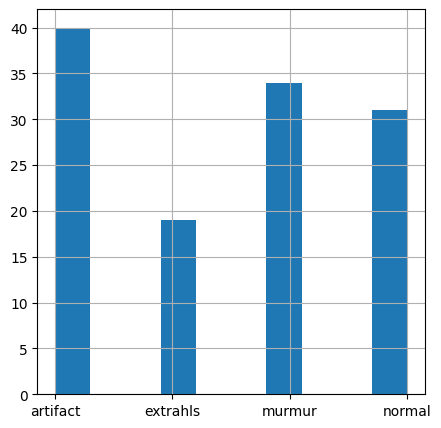

In [5]:
# Now lets plot it for easier comparison between each class, excluding Nan
df_a.label.hist(figsize=(5, 5))

### Set B

In [6]:
df_b = pd.read_csv('heartbeat_data/set_b.csv')
df_b

,dataset,fname,label,sublabel
0,b,set_b/Btraining_extrastole_127_1306764300147_C...,extrastole,NaN
1,b,set_b/Btraining_extrastole_128_1306344005749_A...,extrastole,NaN
2,b,set_b/Btraining_extrastole_130_1306347376079_D...,extrastole,NaN
3,b,set_b/Btraining_extrastole_134_1306428161797_C...,extrastole,NaN
4,b,set_b/Btraining_extrastole_138_1306762146980_B...,extrastole,NaN
...,...,...,...,...
651,b,set_b/Btraining_normal_Btraining_noisynormal_2...,normal,noisynormal
652,b,set_b/Btraining_normal_Btraining_noisynormal_2...,normal,noisynormal
653,b,set_b/Btraining_normal_Btraining_noisynormal_2...,normal,noisynormal
654,b,set_b/Btraining_normal_Btraining_noisynormal_2...,normal,noisynormal


In [7]:
df_b.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 656 entries, 0 to 655
Data columns (total 4 columns):
 #   Column    Non-Null Count  Dtype 
---  ------    --------------  ----- 
 0   dataset   656 non-null    object
 1   fname     656 non-null    object
 2   label     461 non-null    object
 3   sublabel  149 non-null    object
dtypes: object(4)
memory usage: 20.6+ KB


In [8]:
print(df_b["label"].value_counts(dropna=False))

label
normal        320
NaN           195
murmur         95
extrastole     46
Name: count, dtype: int64


<Axes: >

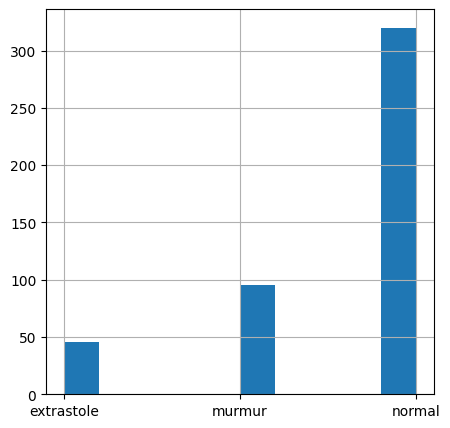

In [9]:
df_b.label.hist(figsize=(5,5))

## SMOTE Experiment (Dataset balancing)
That was clearly imbalanced data. For this exercise, I will experiment with Set A. The reason is smaller instances so it will need smaller resources.
And I will experiment with SMOTE to upsampling class instance

In [10]:
import numpy as np
from imblearn.over_sampling import SMOTE
import librosa
import soundfile as sf
from pathlib import Path
import pandas as pd
from collections import Counter

In [11]:
# Lets define the class name, and we will use Set A
ALLOWED_CLASSES = df_a["label"].dropna().unique().tolist()
ALLOWED_CLASSES


['artifact', 'extrahls', 'murmur', 'normal']

In [12]:
def generate_synthetic_audio(data_dir, class_name, target_count=40, sr=22050):
    """
    Generate synthetic audio samples for underrepresented classes to match target count
    
    Parameters:
    data_dir: directory containing audio files
    target_count: number of samples to match (default 40 for artifact class)
    sr: sampling rate
    """
    # Define allowed classes
    class_names = class_name
    
    # Get all wav files from directory
    data_path = Path(data_dir)
    all_audio_paths = list(data_path.glob('*.wav'))
    
    # Filter files to only include allowed classes
    audio_paths = []
    for path in all_audio_paths:
        label = path.stem.split('__')[0]  # Get label from filename
        if label in class_names:
            audio_paths.append(str(path))
    
    audio_paths = sorted(audio_paths)  # Sort for consistency
    
    # Extract labels from filenames
    labels = [path.split('__')[0].split('\\')[-1] for path in audio_paths]
    # print(f"Labels: {labels}")
    class_counts = Counter(labels)
    
    print(f"Found {len(audio_paths)} files from allowed classes")
    print(f"Class distribution: {class_counts}")
    
    max_length = 0
    audio_data = []
    file_paths = []
    
    # First pass to find maximum length
    for path in audio_paths:
        audio, _ = librosa.load(path, sr=sr)
        max_length = max(max_length, len(audio))
    
    # Second pass to pad all audio to same length
    for path in audio_paths:
        audio, _ = librosa.load(path, sr=sr)
        if len(audio) < max_length:
            audio = np.pad(audio, (0, max_length - len(audio)))
        audio_data.append(audio)
        file_paths.append(path)
    
    # Convert to numpy array
    X = np.array(audio_data)
    y = np.array(labels)
    
    # Calculate number of synthetic samples needed for each class
    synthetic_counts = {}
    for label, count in class_counts.items():
        if count < target_count:
            synthetic_counts[label] = target_count - count
    
    print(f"Will generate synthetic samples: {synthetic_counts}")
    
    # Create synthetic_audio directory inside data_dir
    save_dir = data_path / 'synthetic_audio'
    save_dir.mkdir(exist_ok=True)
    print(f"Saving synthetic samples to: {save_dir}")
    
    # Generate synthetic samples for each underrepresented class
    for label, needed_count in synthetic_counts.items():
        print(f"\nProcessing {label}...")
        
        # Get indices for current class
        class_indices = np.where(y == label)[0]
        X_class = X[class_indices]
        y_class = y[class_indices]
        
        # Apply SMOTE to generate needed number of samples
        smote = SMOTE(sampling_strategy={label: target_count}, random_state=42)
        X_resampled, _ = smote.fit_resample(X, y)
        
        # Get only the synthetic samples (excluding original ones)
        synthetic_samples = X_resampled[len(X):]

        for i, sample in enumerate(synthetic_samples[:needed_count]):
            save_path = save_dir / f"{label}__synthetic_{i+1:02d}.wav"
            sf.write(str(save_path), sample, sr)
            print(f"Saved {save_path}")
    print('Done')


In [13]:
# Set the random seed for reproducibility
np.random.seed(42)

# Use glob to get all wav files, filtering out unlabelled ones
generate_synthetic_audio('heartbeat_data/set_a', class_name=ALLOWED_CLASSES)

Found 124 files from allowed classes
Class distribution: Counter({'artifact': 40, 'murmur': 34, 'normal': 31, 'extrahls': 19})
Will generate synthetic samples: {'extrahls': 21, 'murmur': 6, 'normal': 9}
Saving synthetic samples to: heartbeat_data\set_a\synthetic_audio

Processing extrahls...
Saved heartbeat_data\set_a\synthetic_audio\extrahls__synthetic_01.wav
Saved heartbeat_data\set_a\synthetic_audio\extrahls__synthetic_02.wav
Saved heartbeat_data\set_a\synthetic_audio\extrahls__synthetic_03.wav
Saved heartbeat_data\set_a\synthetic_audio\extrahls__synthetic_04.wav
Saved heartbeat_data\set_a\synthetic_audio\extrahls__synthetic_05.wav
Saved heartbeat_data\set_a\synthetic_audio\extrahls__synthetic_06.wav
Saved heartbeat_data\set_a\synthetic_audio\extrahls__synthetic_07.wav
Saved heartbeat_data\set_a\synthetic_audio\extrahls__synthetic_08.wav
Saved heartbeat_data\set_a\synthetic_audio\extrahls__synthetic_09.wav
Saved heartbeat_data\set_a\synthetic_audio\extrahls__synthetic_10.wav
Saved h

{'artifact': 40, 'extrahls': 40, 'murmur': 40, 'normal': 40}


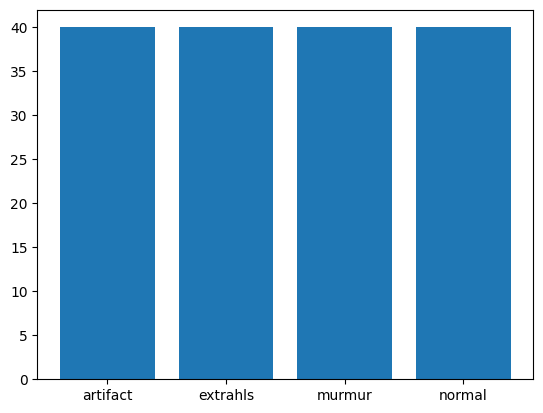

In [14]:
import glob
from collections import defaultdict
import matplotlib.pyplot as plt

# Define the path to the folder and its subdirectories
folder_path = 'heartbeat_data/set_a/**/*.wav'  # Adjust file extension if needed

# Initialize a dictionary to store occurrences
file_count = defaultdict(int)

# Use glob to find all files in the directory and its subdirectories
files = glob.glob(folder_path, recursive=True)

# Process each file and split by '__' to get the first part of the filename
for file in files:
    # Get the filename without path
    filename = file.split('\\')[-1]
    
    # Split the filename by '__' and take the first part
    key = filename.split('__')[0]
    
    # Count occurrences of each key
    if key in ALLOWED_CLASSES:
        file_count[key] += 1

# Convert defaultdict to a regular dictionary (optional)
file_count = dict(file_count)

# Print the result (you can also save it if needed)
print(file_count)

# Create the bar plot
plt.bar(file_count.keys(), file_count.values())

# Display the plot
plt.show()
